# Basic Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of a `bayes_spec` model.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.3.1


## Model Definition

First, we define our model. Here we demonstrate a simple Gaussian line profile model where each "cloud" is expected to produce one Gaussian features. We follow "good" practices by ensuring that the free parameters of the model are normalized so that we are able to efficiently sample the parameter space later. To define a model, we extend the `bayes_spec.BaseModel` class. This class must have three methods: `__init__`, `add_priors`, and `add_likelihood`. This model is copied directly from `bayes_spec.models.gauss_line.py`.

In [2]:
from typing import Iterable

import numpy as np
import pymc as pm

from bayes_spec import BaseModel
from bayes_spec.utils import gaussian


class GaussLine(BaseModel):
    """
    Definition of a Gaussian line profile model.
    """

    def __init__(self, *args, **kwargs):
        """
        Define model parameters, deterministic quantities, posterior
        clustering features, and TeX parameter representations.

        Inputs: see bayes_spec.BaseModel

        Returns: new GaussLine instance
        """
        # Initialize BaseModel
        super().__init__(*args, **kwargs)

        # Define (normalized) cloud free parameter names
        self.cloud_params += [
            "line_area_norm",
            "fwhm_norm",
            "velocity_norm",
        ]

        # Define deterministic quantities (including un-normalized parameters)
        self.deterministics += [
            "line_area",
            "fwhm",
            "velocity",
            "amplitude",
        ]

        # Select features used for posterior clustering
        self._cluster_features += [
            "velocity",
            "line_area",
        ]

        # Define TeX representation of each parameter
        self.var_name_map.update(
            {
                "line_area": r"$\int\!T_B\,dV$ (K km s$^{-1}$)",
                "fwhm": r"$\Delta V$ (km s$^{-1}$)",
                "velocity": r"$V_{\rm LSR}$ (km s$^{-1}$)",
                "amplitude": r"$T_B$ (K)",
            }
        )

    def add_priors(
        self,
        prior_line_area: float = 100.0,
        prior_fwhm: float = 25.0,
        prior_velocity: Iterable[float] = [0.0, 25.0],
        prior_baseline_coeff: float = 1.0,
    ):
        """
        Add priors to the model.

        Inputs:
            prior_line_area :: scalar
                Prior distribution on line area (K km s-1), where:
                line_area ~ Gamma(alpha=2.0, beta=1.0/prior_line_area)
            prior_fwhm :: scalar
                Prior distribution on line area (K km s-1), where:
                line_area ~ Gamma(alpha=2.0, beta=1.0/prior_line_area)
                Mode of the k=2 gamma distribution Gaussian FWHM line width prior
            prior_vlsr :: two-element array of scalars
                Prior distribution on line centroid velocity (km s-1), where:
                velocity ~ Normal(mu=prior_velocity[0], sigma=prior_velocity[1])
            prior_baseline_coeff :: scalar
                Prior distribution on normalized polynomial baseline coefficients, where:
                coeff ~ Normal(mu=0, sigma=prior_baseline_coeffs)

        Returns: Nothing
        """
        # add polynomial baseline priors
        super().add_baseline_priors(prior_baseline_coeff=prior_baseline_coeff)

        with self.model:
            # Line area per cloud
            line_area_norm = pm.Gamma(
                "line_area_norm", alpha=2.0, beta=1.0, dims="cloud"
            )
            line_area = pm.Deterministic(
                "line_area", prior_line_area * line_area_norm, dims="cloud"
            )

            # FWHM line width per cloud
            fwhm_norm = pm.Gamma(
                "fwhm_norm",
                alpha=2.0,
                beta=1.0,
                dims="cloud",
            )
            fwhm = pm.Deterministic("fwhm", prior_fwhm * fwhm_norm, dims="cloud")

            # Centroid velocity per cloud
            velocity_norm = pm.Normal(
                "velocity_norm",
                mu=0.0,
                sigma=1.0,
                dims="cloud",
            )
            _ = pm.Deterministic(
                "velocity",
                prior_velocity[0] + prior_velocity[1] * velocity_norm,
                dims="cloud",
            )

            # Deterministic amplitude per cloud
            _ = pm.Deterministic(
                "amplitude",
                line_area / fwhm / np.sqrt(np.pi / (4.0 * np.log(2.0))),
                dims="cloud",
            )

    def predict(self):
        """
        Predict emission spectrum from model parameters.

        Inputs: None

        Returns: predicted
            predicted :: 1-D array of scalars
                Predicted emission spectrum (K)
        """
        # Evaluate line profile model per cloud, sum over clouds
        predicted_line = gaussian(
            self.data["observation"].spectral[:, None],
            self.model["amplitude"],
            self.model["velocity"],
            self.model["fwhm"],
        ).sum(axis=1)

        # Add baseline model
        baseline_models = self.predict_baseline()
        predicted = predicted_line + baseline_models["observation"]
        return predicted

    def add_likelihood(self):
        """
        Add the likelihood to the model. The SpecData key must be "observation".

        Inputs: None
        Returns: Nothing
        """
        # Predict emission
        predicted = self.predict()

        with self.model:
            # Evaluate likelihood
            _ = pm.Normal(
                "observation",
                mu=predicted,
                sigma=self.data["observation"].noise,
                observed=self.data["observation"].brightness,
            )

## Data Format

We wish to generate some synthetic data from our model, which requires us to take a brief aside to introduce the `bayes_spec` data format. We use the `SpecData` class to pass data into `bayes_spec`.

In [3]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Now that we have a model definition and a dummy data format, we can generate simulated observations by drawing samples from the parameter prior distributions.

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, velocity_norm]


Text(0, 0.5, 'Brightness Temperature (K)')

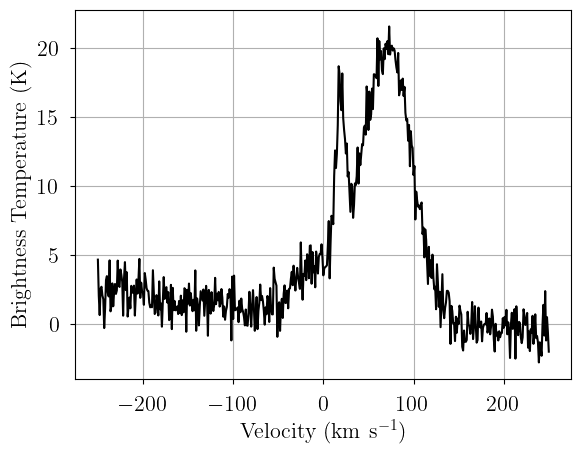

In [4]:
# Initialize and define the model
model = GaussLine(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
)
model.add_likelihood()

# Draw one posterior predictive sample
simulated = model.prior_predictive_check(
    samples=1,
)
sim_brightness = simulated.prior_predictive["observation"].sel(chain=0, draw=0).data

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Alternatively, we can pass the relevant parameters directly to the likelihood variable, named `observation` in our model, to evaluate a model with specific model parameters. Be sure that the simulated values are reasonable given your prior distributions!

Text(0, 0.5, 'Brightness Temperature (K)')

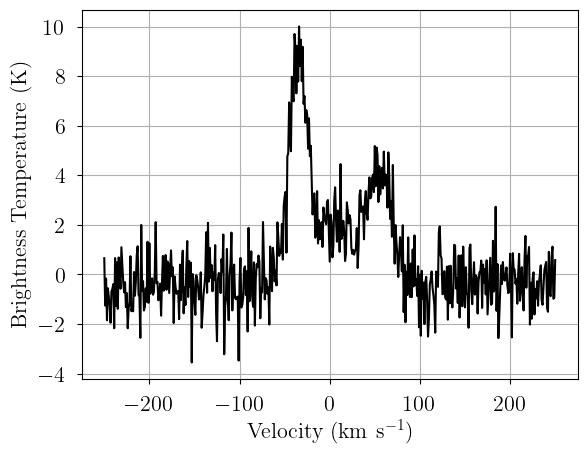

In [5]:
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "observation_baseline_norm": [-0.5, 0.2, 0.05], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [6]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [7]:
model = GaussLine(data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
)
model.add_likelihood()

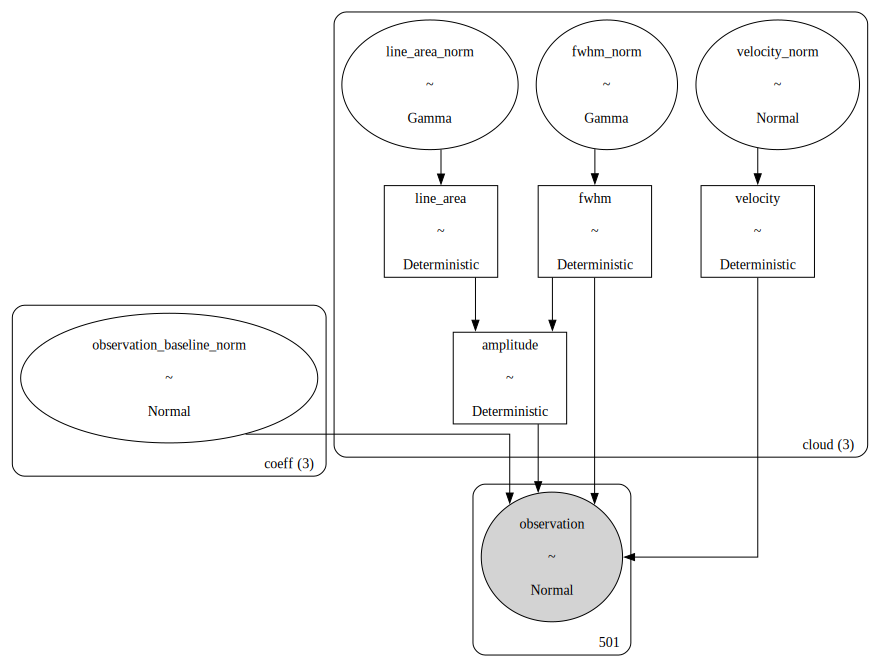

In [8]:
# Plot model graph
model.plot_graph(f"{figdir}/model.gv", "svg")
SVG(f"{figdir}/model.gv.{ext}")

In [9]:
# model string representation
print(model.model.str_repr())

observation_baseline_norm ~ Normal(0, 1)
           line_area_norm ~ Gamma(2, f())
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
                line_area ~ Deterministic(f(line_area_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
                amplitude ~ Deterministic(f(fwhm_norm, line_area_norm))
              observation ~ Normal(f(fwhm_norm, line_area_norm, observation_baseline_norm, velocity_norm), <constant>)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, velocity_norm]


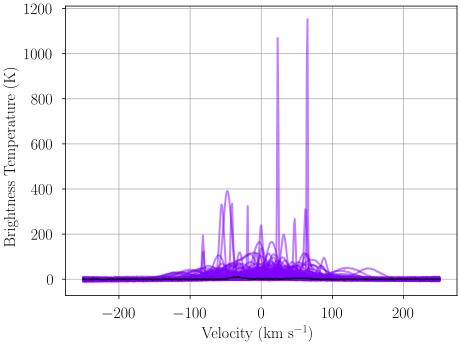

In [10]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive.{ext}",
)
SVG(f"{figdir}/prior_predictive.{ext}")

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has attributes `cloud_params` for cloud free parameters, `deterministics` for deterministic quantities, `baseline_params` for the free polynomial baseline parameters, and `hyper_params` for the hyperparameters. Here we show the pair plot for the deterministic quantities derived from our prior distributions.

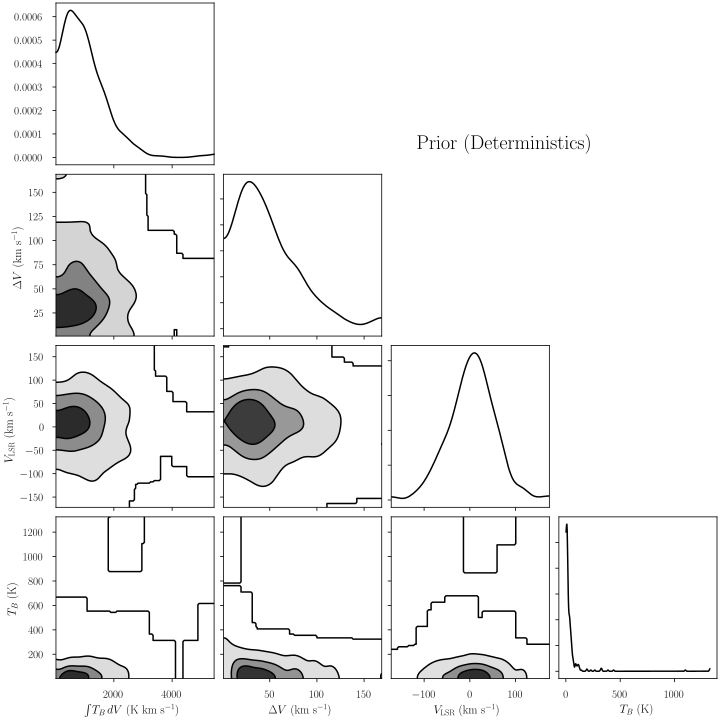

In [11]:
from bayes_spec.plots import plot_pair

plot_pair(
    prior.prior, # samples
    model.deterministics, # var_names to plot
    "Prior (Deterministics)", # plot label
    f"{figdir}/pair_prior_determ.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_prior_determ.{ext}")

## Posterior Sampling: Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. You will have to tune the convergence thresholds and learning rate for your model.

In [12]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 3,834.6


In [13]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.214   0.454    7.356    9.067      0.015   
amplitude[1]                    4.176   0.344    3.553    4.833      0.011   
amplitude[2]                    2.380   0.227    1.999    2.871      0.007   
fwhm[0]                        22.368   0.906   20.811   24.135      0.029   
fwhm[1]                        30.379   1.859   27.045   33.900      0.059   
fwhm[2]                        76.624   5.824   66.610   88.122      0.182   
fwhm_norm[0]                    0.895   0.036    0.832    0.965      0.001   
fwhm_norm[1]                    1.215   0.074    1.082    1.356      0.002   
fwhm_norm[2]                    3.065   0.233    2.664    3.525      0.007   
line_area[0]                  195.236   6.988  182.624  208.574      0.224   
line_area[1]                  134.559   7.543  121.678  149.891      0.237   
line_area[2]                  193.060  11.815  168.012  212.919      0.359   
line_area_norm[0]               0.390   0.014    0.365    0.417      0.000   
line_area_norm[1]               0.269   0.015    0.243    0.300      0.000   
line_area_norm[2]               0.386   0.024    0.336    0.426      0.001   
observation_baseline_norm[0]   -0.464   0.022   -0.507   -0.425      0.001   
observation_baseline_norm[1]    0.038   0.039   -0.042    0.109      0.001   
observation_baseline_norm[2]    0.008   0.050   -0.085    0.096      0.002   
velocity[0]                   -35.220   0.446  -36.026  -34.389      0.015   
velocity[1]                    55.780   0.974   53.845   57.504      0.036   
velocity[2]                     1.932   2.903   -3.316    7.350      0.098   
velocity_norm[0]               -0.704   0.009   -0.721   -0.688      0.000   
velocity_norm[1]                1.116   0.019    1.077    1.150      0.001   
velocity_norm[2]                0.039   0.058   -0.066    0.147      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.011     933.0     938.0    NaN  
amplitude[1]                    0.008     945.0     854.0    NaN  
amplitude[2]                    0.005     964.0    1025.0    NaN  
fwhm[0]                         0.021     946.0     720.0    NaN  
fwhm[1]                         0.041    1019.0     972.0    NaN  
fwhm[2]                         0.129    1024.0     983.0    NaN  
fwhm_norm[0]                    0.001     946.0     720.0    NaN  
fwhm_norm[1]                    0.002    1019.0     972.0    NaN  
fwhm_norm[2]                    0.005    1024.0     983.0    NaN  
line_area[0]                    0.158     955.0     858.0    NaN  
line_area[1]                    0.168    1019.0     790.0    NaN  
line_area[2]                    0.254    1076.0     979.0    NaN  
line_area_norm[0]               0.000     955.0     858.0    NaN  
line_area_norm[1]               0.000    1019.0     790.0    NaN  
line_area_norm[2]               0.001    1076.0     979.0    NaN  
observation_baseline_norm[0]    0.001     993.0     975.0    NaN  
observation_baseline_norm[1]    0.001     982.0     878.0    NaN  
observation_baseline_norm[2]    0.001    1050.0     980.0    NaN  
velocity[0]                     0.011     838.0     932.0    NaN  
velocity[1]                     0.026     706.0     944.0    NaN  
velocity[2]                     0.069     883.0     945.0    NaN  
velocity_norm[0]                0.000     838.0     932.0    NaN  
velocity_norm[1]                0.001     706.0     944.0    NaN  
velocity_norm[2]                0.001     883.0     945.0    NaN

It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks -- realizations of the model drawn with parameters drawn from the posterior distribution. Each line is one posterior sample.

Sampling: [observation]


Output()

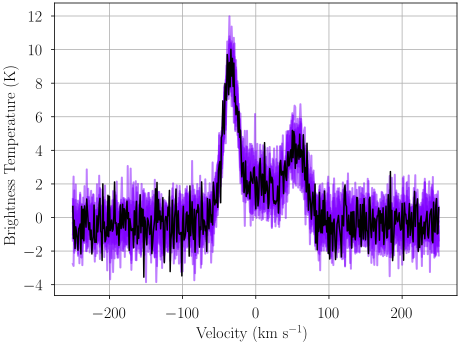

In [14]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_vi.{ext}"
)
SVG(f"{figdir}/posterior_predictive_vi.{ext}")

## Posterior Sampling: MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI (also available is the `pymc` default: `init="jitter+adapt_diag"`, which may be better suited to some models). We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [15]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 3,834.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `p_threshold` defines the probability threshold for "unique" GMM solutions.

In [16]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [17]:
model.trace.solution_0

<xarray.Dataset> Size: 776kB
Dimensions:                    (chain: 4, draw: 1000, cloud: 3, coeff: 3)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * cloud                      (cloud) int64 24B 0 1 2
  * coeff                      (coeff) int64 24B 0 1 2
Data variables:
    amplitude                  (chain, draw, cloud) float64 96kB 8.063 ... 2.55
    fwhm                       (chain, draw, cloud) float64 96kB 23.6 ... 59.4
    fwhm_norm                  (chain, draw, cloud) float64 96kB 0.9439 ... 2...
    line_area                  (chain, draw, cloud) float64 96kB 202.5 ... 161.2
    line_area_norm             (chain, draw, cloud) float64 96kB 0.4051 ... 0...
    observation_baseline_norm  (chain, draw, coeff) float64 96kB -0.5068 ... ...
    velocity                   (chain, draw, cloud) float64 96kB -34.6 ... 1.362
    velocity_norm              (chain, draw, cloud) float64 96kB -0.6921 ... ...
Attributes:
    created_at:     2024-08-05T00:37:31.996899+00:00
    arviz_version:  0.19.0

In [18]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.477   0.526    7.526    9.452      0.016   
amplitude[1]                    4.274   0.382    3.530    4.944      0.009   
amplitude[2]                    2.447   0.233    2.028    2.898      0.004   
fwhm[0]                        23.257   1.515   20.504   26.132      0.042   
fwhm[1]                        31.253   2.811   26.165   36.694      0.068   
fwhm[2]                        64.413  16.408   33.821   91.846      0.536   
fwhm_norm[0]                    0.930   0.061    0.820    1.045      0.002   
fwhm_norm[1]                    1.250   0.112    1.047    1.468      0.003   
fwhm_norm[2]                    2.577   0.656    1.353    3.674      0.021   
line_area[0]                  210.214  22.400  171.973  252.407      0.729   
line_area[1]                  142.411  19.486  107.177  179.642      0.537   
line_area[2]                  167.049  43.740   86.598  242.882      1.443   
line_area_norm[0]               0.420   0.045    0.344    0.505      0.001   
line_area_norm[1]               0.285   0.039    0.214    0.359      0.001   
line_area_norm[2]               0.334   0.087    0.173    0.486      0.003   
observation_baseline_norm[0]   -0.469   0.052   -0.573   -0.373      0.001   
observation_baseline_norm[1]    0.033   0.036   -0.033    0.103      0.001   
observation_baseline_norm[2]   -0.004   0.095   -0.188    0.172      0.002   
velocity[0]                   -35.033   0.470  -35.876  -34.093      0.010   
velocity[1]                    55.715   1.268   53.392   58.196      0.032   
velocity[2]                     3.427   5.428   -7.876   12.720      0.156   
velocity_norm[0]               -0.701   0.009   -0.718   -0.682      0.000   
velocity_norm[1]                1.114   0.025    1.068    1.164      0.001   
velocity_norm[2]                0.069   0.109   -0.158    0.254      0.003   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.011    1179.0    2460.0    1.0  
amplitude[1]                    0.006    1959.0    2381.0    1.0  
amplitude[2]                    0.003    2742.0    2951.0    1.0  
fwhm[0]                         0.030    1288.0    2212.0    1.0  
fwhm[1]                         0.048    1707.0    2334.0    1.0  
fwhm[2]                         0.379     955.0    1405.0    1.0  
fwhm_norm[0]                    0.001    1288.0    2212.0    1.0  
fwhm_norm[1]                    0.002    1707.0    2334.0    1.0  
fwhm_norm[2]                    0.015     955.0    1405.0    1.0  
line_area[0]                    0.516     952.0    1678.0    1.0  
line_area[1]                    0.380    1320.0    1784.0    1.0  
line_area[2]                    1.021     891.0    1379.0    1.0  
line_area_norm[0]               0.001     952.0    1678.0    1.0  
line_area_norm[1]               0.001    1320.0    1784.0    1.0  
line_area_norm[2]               0.002     891.0    1379.0    1.0  
observation_baseline_norm[0]    0.001    1993.0    2060.0    1.0  
observation_baseline_norm[1]    0.000    4255.0    2798.0    1.0  
observation_baseline_norm[2]    0.001    2207.0    2312.0    1.0  
velocity[0]                     0.007    2057.0    2519.0    1.0  
velocity[1]                     0.022    1621.0    1943.0    1.0  
velocity[2]                     0.110    1272.0    1375.0    1.0  
velocity_norm[0]                0.000    2057.0    2519.0    1.0  
velocity_norm[1]                0.000    1621.0    1943.0    1.0  
velocity_norm[2]                0.002    1272.0    1375.0    1.0

We again generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color, and the "thin" lines are the contributions of individual clouds. Each line is one posterior sample.

Sampling: [observation]


Output()

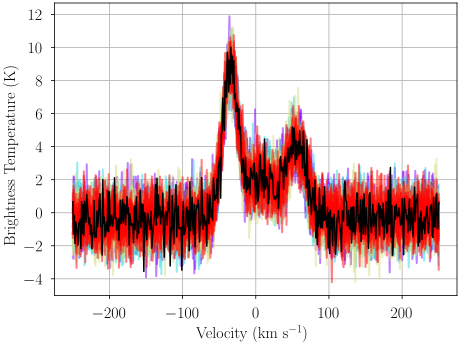

In [19]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive.{ext}"
)
SVG(f"{figdir}/posterior_predictive.{ext}")

In [20]:
model.plot_traces(f"{figdir}/traces.{ext}")
SVG(f"{figdir}/traces.{ext}")

We can inspect the posterior distribution pair plots. First, the (deterministic) cloud parameters.

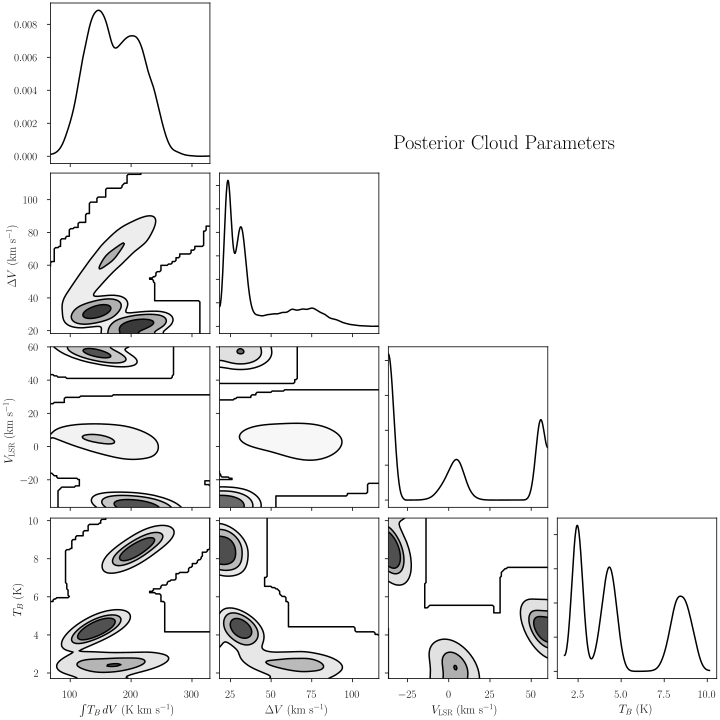

In [21]:
plot_pair(
    model.trace.solution_0, # samples
    model.deterministics, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params.{ext}")

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions for a single cloud.

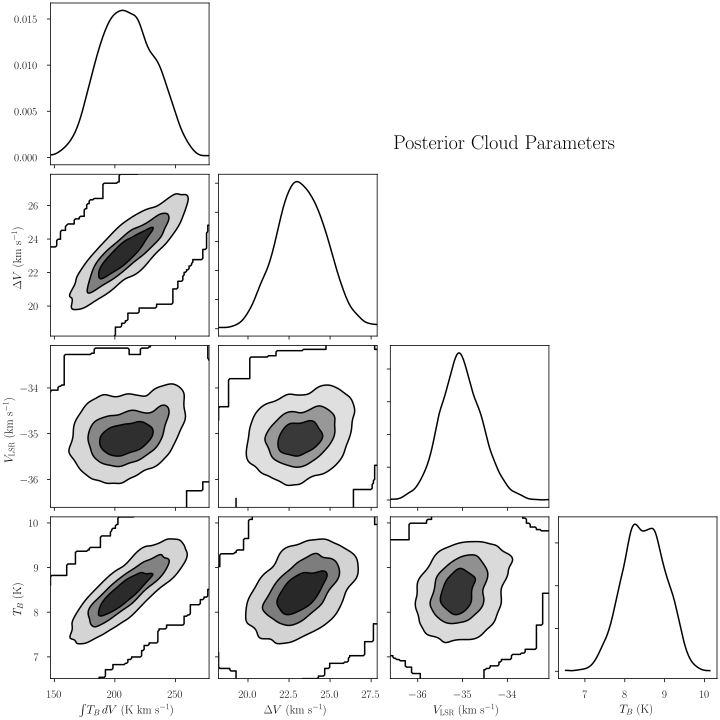

In [22]:
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.deterministics, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_0.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [23]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 1500.2788968346808


mean      sd  hdi_16%  hdi_84%
line_area[0]  210.214  22.400  185.795  233.025
line_area[1]  142.411  19.486  124.911  164.495
line_area[2]  167.049  43.740  109.432  200.948
fwhm[0]        23.257   1.515   21.841   24.854
fwhm[1]        31.253   2.811   28.771   34.400
fwhm[2]        64.413  16.408   49.521   84.454
velocity[0]   -35.033   0.470  -35.548  -34.628
velocity[1]    55.715   1.268   54.484   56.958
velocity[2]     3.427   5.428   -0.900    9.450
amplitude[0]    8.477   0.526    7.962    9.044
amplitude[1]    4.274   0.382    3.923    4.689
amplitude[2]    2.447   0.233    2.216    2.681